In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz


# Cleaning data as advised in HOMEWORK 1 guidelines

In [2]:
# reading csv file
df = pd.read_csv('AnimalWelfareRisk-19205519.csv', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)




In [3]:
# changed column names to make them consistent
df.columns = df.columns.str.replace(' ', '_')
df.columns = map(str.lower, df.columns)
df.columns

Index(['animal_id', 'name_intake', 'datetime_intake', 'monthyear_intake',
       'found_location', 'intake_type', 'intake_condition',
       'animal_type_intake', 'sex_upon_intake', 'age_upon_intake',
       'breed_intake', 'color_intake', 'name_outcome', 'datetime_outcome',
       'monthyear_outcome', 'date_of_birth', 'animal_type_outcome',
       'sex_upon_outcome', 'age_upon_outcome', 'breed_outcome',
       'color_outcome', 'binary_outcome'],
      dtype='object')

In [4]:
# drop duplucates 
df = df.T.drop_duplicates().T
df = df.drop('name_intake', 1)
df.columns

Index(['animal_id', 'datetime_intake', 'found_location', 'intake_type',
       'intake_condition', 'animal_type_intake', 'sex_upon_intake',
       'age_upon_intake', 'breed_intake', 'color_intake', 'datetime_outcome',
       'date_of_birth', 'sex_upon_outcome', 'age_upon_outcome',
       'binary_outcome'],
      dtype='object')

Converting datatypes:

In [5]:
# converting object to category
df["intake_type"] = df["intake_type"].astype('category')
df["intake_condition"] = df["intake_condition"].astype('category')
df["animal_type_intake"] = df["animal_type_intake"].astype('category')
df["sex_upon_intake"] = df["sex_upon_intake"].astype('category')
df["breed_intake"] = df["breed_intake"].astype('category')
df["color_intake"] = df["color_intake"].astype('category')
df["sex_upon_outcome"] = df["sex_upon_outcome"].astype('category')
df["found_location"] = df["found_location"].astype('category')
df["age_upon_outcome"] = df["age_upon_outcome"].astype('category')


# converting strings to datetime
df["datetime_intake"] = df["datetime_intake"].astype('datetime64[ns]')
df["datetime_outcome"] = df["datetime_outcome"].astype('datetime64[ns]')
df["date_of_birth"] = df["date_of_birth"].astype('datetime64[ns]')


# converting float to boolean
df["binary_outcome"] = df["binary_outcome"].astype('bool_')


df.dtypes

animal_id                     object
datetime_intake       datetime64[ns]
found_location              category
intake_type                 category
intake_condition            category
animal_type_intake          category
sex_upon_intake             category
age_upon_intake               object
breed_intake                category
color_intake                category
datetime_outcome      datetime64[ns]
date_of_birth         datetime64[ns]
sex_upon_outcome            category
age_upon_outcome            category
binary_outcome                  bool
dtype: object

Apply a custom function to separate sex and neuter status:

In [6]:
# Apply a custom function to separate sex and neuter status

def parse_neuter_status(input_string):
    if ("Neutered" in input_string) or ("Spayed" in input_string):
        return "Neutered"
    else:
        return "Not neutered"
    
def parse_sex(input_string):
    if ("Female" in input_string):
        return "Female"
    elif ("Male" in input_string):
        return "Male"
    else:
        return None

df['neuter_status_intake'] = df.sex_upon_intake.apply(parse_neuter_status)
df['sex'] = df.sex_upon_intake.apply(parse_sex)

df['neuter_status_outcome'] = df.sex_upon_outcome.apply(parse_neuter_status)


df = df.drop('sex_upon_outcome', 1)
df = df.drop('sex_upon_intake', 1)
df.tail(5)

,animal_id,datetime_intake,found_location,intake_type,intake_condition,animal_type_intake,age_upon_intake,breed_intake,color_intake,datetime_outcome,date_of_birth,age_upon_outcome,binary_outcome,neuter_status_intake,sex,neuter_status_outcome
995,A807512,2019-10-25 15:46:00,Walnut Creek Park Road And North Lamar Bouleva...,Stray,Normal,Cat,1 month,Domestic Shorthair,Brown Tabby,2019-10-30 18:25:00,2019-09-19,1 month,False,Not neutered,Male,Not neutered
996,A742592,2017-01-24 16:20:00,2400 Mozelle in Travis (TX),Owner Surrender,Normal,Dog,6 years,Pembroke Welsh Corgi Mix,Red,2017-02-11 18:28:00,2011-01-24,6 years,True,Neutered,Male,Neutered
997,A711609,2015-09-09 15:14:00,845 N Meadows Dr #A in Austin (TX),Stray,Injured,Cat,2 years,Domestic Shorthair Mix,White/Gray,2015-09-09 15:17:00,2013-09-09,2 years,True,Not neutered,None,Not neutered
998,A719244,2016-01-16 08:35:00,5511 Blue Bluff Rd in Travis (TX),Stray,Injured,Dog,10 years,Labrador Retriever Mix,Brown,2016-01-21 16:50:00,2006-01-16,10 years,False,Neutered,Male,Neutered
999,A727694,2016-05-25 07:54:00,12812 Thomas Jefferson in Travis (TX),Stray,Injured,Cat,3 years,Domestic Shorthair Mix,Orange Tabby,2016-06-28 17:56:00,2013-05-24,3 years,False,Not neutered,Male,Neutered


Change age into days by applying custom funtion

In [7]:
# change age into days applying custom funtion

def calculate_days(age_string):
    if "year" in age_string:
        num_list = age_string.split(" ", 1)
        num = num_list[0]
        days_number = int(num) * 365
    elif "month" in age_string:
        num_list = age_string.split(" ", 1)
        num = num_list[0]
        days_number = int(num) * 30.41
    elif "week" in age_string:
        num_list = age_string.split(" ", 1)
        num = num_list[0]
        days_number = int(num) * 7
    elif "day" in age_string:
        num_list = age_string.split(" ", 1)
        num = num_list[0]
        days_number = int(num) * 1
    else:
        days_number = -1
    
    # avoid decimals due to estimation as we do not know which calendar months are referred to
    return round(days_number)

# Create feature age_upon_intake_days and age_upon_outcome_days
df['age_upon_intake_days'] = df.age_upon_intake.apply(calculate_days)
df['age_upon_outcome_days'] = df.age_upon_outcome.apply(calculate_days)


df = df.drop('age_upon_intake', 1)
df = df.drop('age_upon_outcome', 1)


Create feature time_in_shelter from date_time_outcome and date_time_intake

In [8]:
# Create feature time_in_shelter from datetime_outcome and datetime_intake
df["time_in_shelter"] = df["datetime_outcome"] - df["datetime_intake"]

# Create feature month_intake and month_outcome from datetime_intake and datetime_outcome
# to be able to use the data in later analysis
df["month_intake"] = df["datetime_intake"].dt.month
df["month_outcome"] = df["datetime_outcome"].dt.month

In [9]:
df.dtypes

animal_id                         object
datetime_intake           datetime64[ns]
found_location                  category
intake_type                     category
intake_condition                category
animal_type_intake              category
breed_intake                    category
color_intake                    category
datetime_outcome          datetime64[ns]
date_of_birth             datetime64[ns]
binary_outcome                      bool
neuter_status_intake              object
sex                               object
neuter_status_outcome             object
age_upon_intake_days               int64
age_upon_outcome_days              int64
time_in_shelter          timedelta64[ns]
month_intake                       int64
month_outcome                      int64
dtype: object

Change datatype of the new features

In [10]:
df["neuter_status_intake"] = df["neuter_status_intake"].astype('category')
df["sex"] = df["sex"].astype('category')
df["neuter_status_outcome"] = df["neuter_status_outcome"].astype('category')
df["month_intake"] = df["month_intake"].astype('category')
df["month_outcome"] = df["month_outcome"].astype('category')

df.dtypes

animal_id                         object
datetime_intake           datetime64[ns]
found_location                  category
intake_type                     category
intake_condition                category
animal_type_intake              category
breed_intake                    category
color_intake                    category
datetime_outcome          datetime64[ns]
date_of_birth             datetime64[ns]
binary_outcome                      bool
neuter_status_intake            category
sex                             category
neuter_status_outcome           category
age_upon_intake_days               int64
age_upon_outcome_days              int64
time_in_shelter          timedelta64[ns]
month_intake                    category
month_outcome                   category
dtype: object

Remove negative values for time_in_shelter

In [11]:
df["time_in_shelter_days"] = df["time_in_shelter"].dt.days

# Apply a custom function to remove negative values

def remove_negatives(input_value):
    if input_value < 0:
        return None
    else:
        return input_value

df['time_in_shelter_days'] = df.time_in_shelter_days.apply(remove_negatives)

Group found_location into cities, dropping the address

In [12]:
found_location = df["found_location"]

city_found = []
for i in found_location:
    if " in " in i:
        address, city = i.split(' in ')
        city_found.append(city)
    else:
        city_found.append(i)

found_city = pd.Series(city_found, dtype='category')
df['found_city'] = found_city
    

In [13]:
df['breed_intake'].value_counts()

Domestic Shorthair Mix          276
Pit Bull Mix                     73
Labrador Retriever Mix           54
Chihuahua Shorthair Mix          49
Domestic Shorthair               37
                               ... 
Labrador Retriever/Beagle         1
Jack Russell Terrier/Basenji      1
Himalayan Mix                     1
Heron Mix                         1
Abyssinian Mix                    1
Name: breed_intake, Length: 220, dtype: int64

Group breeds as to reduce cardinality

In [14]:
breed_intake = df["breed_intake"]
animal_type_intake = df["animal_type_intake"]

breed = []

for k in animal_type_intake:
    for i in breed_intake:
        if "Domestic" in i:
            if k == "Cat":
                breed.append("Domestic Mixed")
            else:
                breed.append("Domestic Mixed Dog")
        elif "Mix" in i:
            actual_breed = i.split(' Mix')[0]
            breed.append(actual_breed)
        elif "/" in i:
            actual_breed = i.split('/')[0]
            breed.append(actual_breed)
        else:
            breed.append(i)

animal_breed = pd.Series(breed, dtype='category')
df['animal_breed'] = animal_breed

In [15]:
df['animal_breed'].value_counts()

Domestic Mixed         370
Pit Bull                81
Labrador Retriever      68
Chihuahua Shorthair     67
German Shepherd         26
                      ... 
Californian              1
Muscovy                  1
Bull Terrier             1
Abyssinian               1
Domestic Mixed Dog       0
Name: animal_breed, Length: 110, dtype: int64

In [16]:
df.head(50)

,animal_id,datetime_intake,found_location,intake_type,intake_condition,animal_type_intake,breed_intake,color_intake,datetime_outcome,date_of_birth,...,sex,neuter_status_outcome,age_upon_intake_days,age_upon_outcome_days,time_in_shelter,month_intake,month_outcome,time_in_shelter_days,found_city,animal_breed
0,A783167,2018-12-15 13:56:00,11711 Domain Drive in Austin (TX),Owner Surrender,Normal,Cat,Domestic Medium Hair Mix,Blue Tabby,2018-12-15 18:38:00,2018-06-26,...,Female,Neutered,152,152,0 days 04:42:00,12,12,0.0,Austin (TX),Domestic Mixed
1,A753133,2017-07-02 11:03:00,9414 N Lamar Blvd in Austin (TX),Stray,Normal,Dog,Pit Bull Mix,Black/White,2017-07-10 18:42:00,2017-01-02,...,Female,Neutered,152,182,8 days 07:39:00,7,7,8.0,Austin (TX),Pit Bull
2,A760404,2017-10-17 17:38:00,5301 Wasson Road in Austin (TX),Stray,Normal,Cat,Domestic Shorthair Mix,Black,2017-10-17 19:01:00,2017-10-14,...,NaN,Not neutered,3,3,0 days 01:23:00,10,10,0.0,Austin (TX),Domestic Mixed
3,A773372,2018-05-31 11:52:00,Austin (TX),Owner Surrender,Normal,Cat,Domestic Shorthair Mix,Brown Tabby/White,2018-07-06 14:35:00,2017-05-31,...,Female,Neutered,365,365,36 days 02:43:00,5,7,36.0,Austin (TX),Domestic Mixed
4,A789156,2019-02-16 11:25:00,Westgate Boulevard And Bushnell Drive in Austi...,Stray,Normal,Dog,Yorkshire Terrier Mix,Brown/Black,2019-02-20 16:49:00,2009-02-16,...,Female,Neutered,3650,3650,4 days 05:24:00,2,2,4.0,Austin (TX),Yorkshire Terrier
5,A761920,2017-11-28 18:50:00,Travis (TX),Public Assist,Normal,Dog,Pit Bull Mix,Tan,2017-12-10 17:56:00,2014-11-11,...,Female,Not neutered,1095,1095,11 days 23:06:00,11,12,11.0,Travis (TX),Pit Bull
6,A726377,2016-05-10 12:50:00,3416 River Rd in Travis (TX),Stray,Normal,Dog,Australian Cattle Dog,Blue/Black,2016-05-14 00:00:00,2016-03-10,...,Female,Neutered,30,61,3 days 11:10:00,5,5,3.0,Travis (TX),Australian Cattle Dog
7,A720373,2016-02-08 11:24:00,Burnell And Langston in Austin (TX),Stray,Normal,Dog,Staffordshire Mix,Brown Brindle,2016-02-15 18:53:00,2015-02-08,...,Female,Neutered,365,365,7 days 07:29:00,2,2,7.0,Austin (TX),Staffordshire
8,A712167,2015-09-18 16:43:00,600 Congress in Austin (TX),Public Assist,Normal,Other,Bat,Black,2015-09-18 17:23:00,2014-09-18,...,NaN,Not neutered,365,365,0 days 00:40:00,9,9,0.0,Austin (TX),Bat
9,A769388,2018-04-04 13:07:00,2110 West Slaughter Lane in Austin (TX),Stray,Nursing,Dog,Labrador Retriever Mix,Chocolate/Tan,2018-04-04 13:10:00,2018-03-31,...,Male,Not neutered,4,4,0 days 00:03:00,4,4,0.0,Austin (TX),Labrador Retriever


In [17]:
animal_breed = df["animal_breed"]

breed = []
for i in animal_breed:
    if "Shorthair" in i:
        actual_breed = i.split('Shorthair')[0]
        breed.append(actual_breed)
    elif "Longhair" in i:
        actual_breed = i.split('Longhair')[0]
        breed.append(actual_breed)
    elif "Medium Hair" in i:
        actual_breed = i.split('Medium Hair')[0]
        breed.append(actual_breed)
    else:
        breed.append(i)

animal_breed = pd.Series(breed, dtype='category')
df['animal_breed'] = animal_breed

In [18]:
df['animal_breed'] = np.where(df.groupby('animal_breed')['animal_breed'].transform('size') < 10, 'other', df['animal_breed'])

In [19]:
df['animal_breed'].value_counts()

Domestic Mixed           370
other                    229
Pit Bull                  81
Chihuahua                 71
Labrador Retriever        68
German Shepherd           26
Bat                       21
Australian Cattle Dog     20
Yorkshire Terrier         15
Raccoon                   14
Siamese                   12
Dachshund                 12
Catahoula                 11
Boxer                     10
Beagle                    10
Miniature Poodle          10
Great Pyrenees            10
Border Collie             10
Name: animal_breed, dtype: int64

In [20]:
df['color_intake'].value_counts()

Black/White     99
Black           88
Brown Tabby     66
Brown           38
White/Black     35
                ..
White/Calico     1
Orange/White     1
Tan/Tricolor     1
Cream/Tan        1
Calico Point     1
Name: color_intake, Length: 112, dtype: int64

Group colors as to reduce cardinality

In [21]:
color_intake = df["color_intake"]

color = []

for j in color_intake:
    if "/" in j:
        actual_color = j.split('/')[0]
        color.append(actual_color)
    else:
        color.append(j)
        
animal_color = pd.Series(color, dtype='category')
df['animal_color'] = animal_color



color2 = []
for i in animal_color:
    if "Tabby" in i:
        actual_color = i.replace("Tabby", "")
        color2.append(actual_color)
    elif "Brown" in i:
        actual_color = "Brown"
        color2.append(actual_color)
    elif "Tortie" in i:
        actual_color = i.replace("Tortie", "Tricolor")
        color2.append(actual_color)
    elif "Yellow" in i:
        actual_color = i.replace("Yellow", "Gold")
        color2.append(actual_color)
    elif "Cream" in i:
        actual_color = i.replace("Cream", "Gold")
        color2.append(actual_color)
    elif "Chocolate" in i:
        actual_color = i.replace("Chocolate", "Brown")
        color2.append(actual_color)
    elif "Calico" in i:
        actual_color = i.replace("Calico", "Tricolor")
        color2.append(actual_color)
    elif "Point" in i:
        actual_color = i.split('Point')[0]
        color2.append(actual_color)
    else:
        color2.append(i)
    

animal_color = pd.Series(color2, dtype='category')
df['animal_color'] = animal_color

In [22]:
color2 = []
for i in animal_color:
    if "Brown" in i:
        actual_color = "Brown"
        color2.append(actual_color)
    elif "Blue" in i:
        actual_color = "Blue"
        color2.append(actual_color)
    else:
       color2.append(i) 
animal_color = pd.Series(color2, dtype='category')
df['animal_color'] = animal_color

In [23]:
df['animal_color'] = np.where(df.groupby('animal_color')['animal_color'].transform('size') < 10, 'other', df['animal_color'])

In [24]:
df['animal_color'].value_counts()

Black       249
Brown       238
White       128
Blue         73
Tan          70
Tricolor     61
other        49
Orange       41
Red          28
Gray         24
Gold         19
Sable        10
Torbie       10
Name: animal_color, dtype: int64

In [25]:
df.head()

,animal_id,datetime_intake,found_location,intake_type,intake_condition,animal_type_intake,breed_intake,color_intake,datetime_outcome,date_of_birth,...,neuter_status_outcome,age_upon_intake_days,age_upon_outcome_days,time_in_shelter,month_intake,month_outcome,time_in_shelter_days,found_city,animal_breed,animal_color
0,A783167,2018-12-15 13:56:00,11711 Domain Drive in Austin (TX),Owner Surrender,Normal,Cat,Domestic Medium Hair Mix,Blue Tabby,2018-12-15 18:38:00,2018-06-26,...,Neutered,152,152,0 days 04:42:00,12,12,0.0,Austin (TX),Domestic Mixed,Blue
1,A753133,2017-07-02 11:03:00,9414 N Lamar Blvd in Austin (TX),Stray,Normal,Dog,Pit Bull Mix,Black/White,2017-07-10 18:42:00,2017-01-02,...,Neutered,152,182,8 days 07:39:00,7,7,8.0,Austin (TX),Pit Bull,Black
2,A760404,2017-10-17 17:38:00,5301 Wasson Road in Austin (TX),Stray,Normal,Cat,Domestic Shorthair Mix,Black,2017-10-17 19:01:00,2017-10-14,...,Not neutered,3,3,0 days 01:23:00,10,10,0.0,Austin (TX),Domestic Mixed,Black
3,A773372,2018-05-31 11:52:00,Austin (TX),Owner Surrender,Normal,Cat,Domestic Shorthair Mix,Brown Tabby/White,2018-07-06 14:35:00,2017-05-31,...,Neutered,365,365,36 days 02:43:00,5,7,36.0,Austin (TX),Domestic Mixed,Brown
4,A789156,2019-02-16 11:25:00,Westgate Boulevard And Bushnell Drive in Austi...,Stray,Normal,Dog,Yorkshire Terrier Mix,Brown/Black,2019-02-20 16:49:00,2009-02-16,...,Neutered,3650,3650,4 days 05:24:00,2,2,4.0,Austin (TX),Yorkshire Terrier,Brown


Save dataset to cleaned csv

In [26]:
df.to_csv('AnimalWelfareRisk-19205519.cleaned2.csv', index=False)

# HOMEWORK 2

## 1.0 Data Understanding and Prep

The first step is to import the cleaned data set we will work with

In [27]:
df = pd.read_csv('AnimalWelfareRisk-19205519.cleaned2.csv', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

Now I will check the shape and the datatypes to make sure we are working with the correct data set

In [28]:
df.shape

(1000, 23)

In [29]:
df.head()

,animal_id,datetime_intake,found_location,intake_type,intake_condition,animal_type_intake,breed_intake,color_intake,datetime_outcome,date_of_birth,...,neuter_status_outcome,age_upon_intake_days,age_upon_outcome_days,time_in_shelter,month_intake,month_outcome,time_in_shelter_days,found_city,animal_breed,animal_color
0,A783167,2018-12-15 13:56:00,11711 Domain Drive in Austin (TX),Owner Surrender,Normal,Cat,Domestic Medium Hair Mix,Blue Tabby,2018-12-15 18:38:00,2018-06-26 00:00:00,...,Neutered,152,152,0 days 04:42:00.000000000,12,12,0.0,Austin (TX),Domestic Mixed,Blue
1,A753133,2017-07-02 11:03:00,9414 N Lamar Blvd in Austin (TX),Stray,Normal,Dog,Pit Bull Mix,Black/White,2017-07-10 18:42:00,2017-01-02 00:00:00,...,Neutered,152,182,8 days 07:39:00.000000000,7,7,8.0,Austin (TX),Pit Bull,Black
2,A760404,2017-10-17 17:38:00,5301 Wasson Road in Austin (TX),Stray,Normal,Cat,Domestic Shorthair Mix,Black,2017-10-17 19:01:00,2017-10-14 00:00:00,...,Not neutered,3,3,0 days 01:23:00.000000000,10,10,0.0,Austin (TX),Domestic Mixed,Black
3,A773372,2018-05-31 11:52:00,Austin (TX),Owner Surrender,Normal,Cat,Domestic Shorthair Mix,Brown Tabby/White,2018-07-06 14:35:00,2017-05-31 00:00:00,...,Neutered,365,365,36 days 02:43:00.000000000,5,7,36.0,Austin (TX),Domestic Mixed,Brown
4,A789156,2019-02-16 11:25:00,Westgate Boulevard And Bushnell Drive in Austi...,Stray,Normal,Dog,Yorkshire Terrier Mix,Brown/Black,2019-02-20 16:49:00,2009-02-16 00:00:00,...,Neutered,3650,3650,4 days 05:24:00.000000000,2,2,4.0,Austin (TX),Yorkshire Terrier,Brown


In [30]:
df.dtypes

animal_id                 object
datetime_intake           object
found_location            object
intake_type               object
intake_condition          object
animal_type_intake        object
breed_intake              object
color_intake              object
datetime_outcome          object
date_of_birth             object
binary_outcome              bool
neuter_status_intake      object
sex                       object
neuter_status_outcome     object
age_upon_intake_days       int64
age_upon_outcome_days      int64
time_in_shelter           object
month_intake               int64
month_outcome              int64
time_in_shelter_days     float64
found_city                object
animal_breed              object
animal_color              object
dtype: object

Before correcting the datatypes, we will drop some features that will not be used:
<br>
color_intake - I have created a feature called animal_color as explained above in Homework one, meaning there is no need to keep color_intake.
<br>
breed_intake - I have created a feature called animal_breed as explained above in Homework one, meaning there is no need to keep breed_intake.
<br>
found_location - I have created a feature called found_city as explained above in Homework one, meaning there is no need to keep found_location.
<br>
time_in_shelter, datetime_intake and datetime_outcome - I have created a feature called time_in_shelter_days as explained above in Homework one, meaning there is no need to keep these three features.
<br>
animal_id - ???????????????????????

In [31]:
df = df.drop(['color_intake', 'breed_intake', 'found_location', 'animal_id','time_in_shelter', 'datetime_intake', 'datetime_outcome', 'date_of_birth'], axis=1)


As we can see above, some of the datatypes are not correct, so I will change some of them.

In [32]:
# converting object to category
df["intake_type"] = df["intake_type"].astype('category')
df["intake_condition"] = df["intake_condition"].astype('category')
df["animal_type_intake"] = df["animal_type_intake"].astype('category')
df["neuter_status_intake"] = df["neuter_status_intake"].astype('category')
df["sex"] = df["sex"].astype('category')
df["neuter_status_outcome"] = df["neuter_status_outcome"].astype('category')
df["found_city"] = df["found_city"].astype('category')
df["animal_breed"] = df["animal_breed"].astype('category')
df["animal_color"] = df["animal_color"].astype('category')
df["month_intake"] = df["month_intake"].astype('category')
df["month_outcome"] = df["month_outcome"].astype('category')

# converting float to boolean
df["binary_outcome"] = df["binary_outcome"].astype('int64')


df.dtypes

intake_type              category
intake_condition         category
animal_type_intake       category
binary_outcome              int64
neuter_status_intake     category
sex                      category
neuter_status_outcome    category
age_upon_intake_days        int64
age_upon_outcome_days       int64
month_intake             category
month_outcome            category
time_in_shelter_days      float64
found_city               category
animal_breed             category
animal_color             category
dtype: object

Now that we know we have the correct data, I will check first for any null values

In [33]:
df.isna().sum()

intake_type                0
intake_condition           0
animal_type_intake         0
binary_outcome             0
neuter_status_intake       0
sex                      107
neuter_status_outcome      0
age_upon_intake_days       0
age_upon_outcome_days      0
month_intake               0
month_outcome              0
time_in_shelter_days      12
found_city                 0
animal_breed               0
animal_color               0
dtype: int64

NaN values appear in features sex and time_in_shelter_days. Since there are a few different ways of dealing with NaN values, I will assess each approach below:
- Imputation: fills in the NaN values with substituted values. Here I am using the median to calculate the substitutes.
- Strage value: fills in the NaN values with a random strange value so it's not empty. I have chosen '999' as my random value.

In [34]:
# 1. Perform imputation with median
df['time_in_shelter_days_imputation'] = df['time_in_shelter_days'].fillna(df['time_in_shelter_days'].median()).astype('float64')
# 2. Replace with strange value
df['time_in_shelter_days_strange_value'] = df['time_in_shelter_days'].fillna(999).astype('float64')


Below I am checking the correlation between binary_outcome and the new substituted values in order to make a decision as how to deal with this issue.

In [35]:
NetFractionInstallBurden_corr = df[['time_in_shelter_days_imputation','time_in_shelter_days_strange_value','time_in_shelter_days', 'binary_outcome']].corr()
NetFractionInstallBurden_corr

,time_in_shelter_days_imputation,time_in_shelter_days_strange_value,time_in_shelter_days,binary_outcome
time_in_shelter_days_imputation,1.000000,0.326829,1.000000,-0.079148
time_in_shelter_days_strange_value,0.326829,1.000000,1.000000,-0.029565
time_in_shelter_days,1.000000,1.000000,1.000000,-0.079704
binary_outcome,-0.079148,-0.029565,-0.079704,1.000000


 - time_in_shelter_days (0.079704) has the best correlation. However, I cannot use this as there are null values.
 - time_in_shelter_days_imputation (-0.079148) has the closest correlation to the original feature.
 - time_in_shelter_days_strange_value (-0.029565) has a correlation that is not as close as the median approach.
 
 Based on the evidence above, I have decided to drop the time_in_shelter_days_strange_value and keep time_in_shelter_days_imputation.

In [36]:
df = df.drop(['time_in_shelter_days_strange_value','time_in_shelter_days',],1)

In [37]:
# Replace NaN with unknow 
df['sex'] = df['sex'].cat.add_categories("Unknown")

Grouping continuous, categorical and datetime columns so as to be able to plot them later

## 1.1 Randomly shuffle the rows and split the dataset into two datasets: 70% training and 30% test
Now that I have dealt with the NaN values, before splitting the dataset, I will shuffle the dataframe 

In [38]:
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)

,intake_type,intake_condition,animal_type_intake,binary_outcome,neuter_status_intake,sex,neuter_status_outcome,age_upon_intake_days,age_upon_outcome_days,month_intake,month_outcome,found_city,animal_breed,animal_color,time_in_shelter_days_imputation
0,Owner Surrender,Normal,Cat,0,Neutered,Female,Neutered,152,152,12,12,Austin (TX),Domestic Mixed,Blue,0.0
1,Stray,Normal,Dog,0,Not neutered,Female,Neutered,152,182,7,7,Austin (TX),Pit Bull,Black,8.0
2,Stray,Normal,Cat,0,Not neutered,NaN,Not neutered,3,3,10,10,Austin (TX),Domestic Mixed,Black,0.0
3,Owner Surrender,Normal,Cat,0,Not neutered,Female,Neutered,365,365,5,7,Austin (TX),Domestic Mixed,Brown,36.0
4,Stray,Normal,Dog,0,Neutered,Female,Neutered,3650,3650,2,2,Austin (TX),Yorkshire Terrier,Brown,4.0


I will now split the the dataset into two datasets:
- 70% training
- 30% test

In [39]:
y = pd.DataFrame(df["binary_outcome"])
X = df.drop(["binary_outcome"],1)

In [40]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  1000
training range (70%):	 rows 0 to 700
test range (30%): 	 rows 700 to 1000


In [41]:
continuous_columns = df.select_dtypes(['int64', 'float64']).columns
date_time_columns = df.select_dtypes(['datetime64[ns]']).columns
categorical_columns = df.select_dtypes(['category']).columns

In [42]:
continuous_columns

Index(['binary_outcome', 'age_upon_intake_days', 'age_upon_outcome_days',
       'time_in_shelter_days_imputation'],
      dtype='object')

In [43]:
df.dtypes

intake_type                        category
intake_condition                   category
animal_type_intake                 category
binary_outcome                        int64
neuter_status_intake               category
sex                                category
neuter_status_outcome              category
age_upon_intake_days                  int64
age_upon_outcome_days                 int64
month_intake                       category
month_outcome                      category
found_city                         category
animal_breed                       category
animal_color                       category
time_in_shelter_days_imputation     float64
dtype: object

In [44]:
continuous_columns = continuous_columns.drop('binary_outcome')

In [45]:
df[continuous_columns].dtypes

age_upon_intake_days                 int64
age_upon_outcome_days                int64
time_in_shelter_days_imputation    float64
dtype: object

In [46]:
df[date_time_columns].dtypes

Series([], dtype: object)

In [47]:
df[categorical_columns].dtypes

intake_type              category
intake_condition         category
animal_type_intake       category
neuter_status_intake     category
sex                      category
neuter_status_outcome    category
month_intake             category
month_outcome            category
found_city               category
animal_breed             category
animal_color             category
dtype: object

## 1.2 The training set
Now that I have shuffled the dataframe and have separated the dataset into two: training and testing, I will plot the correlations and discuss my findings. I will also choose a subset of features that seem better at predicting the target feature and explain my choices.

(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

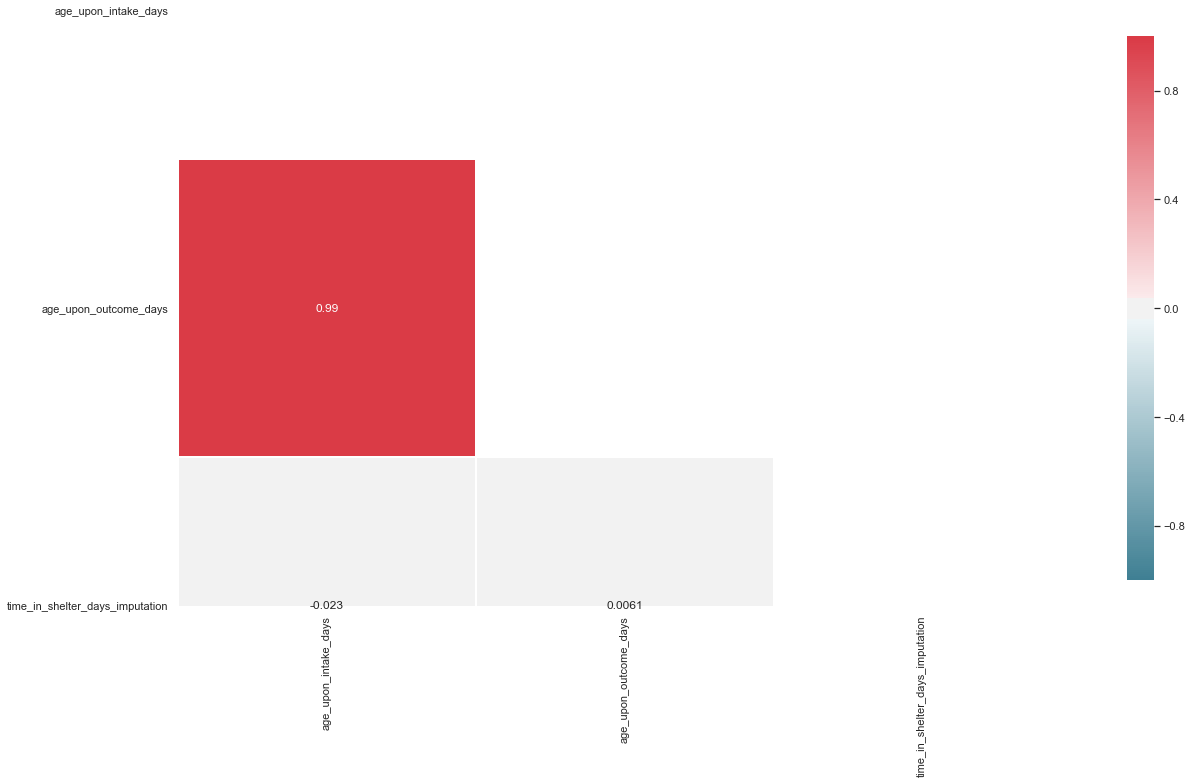

In [48]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

## Interpretation of the results:
- Strong correlation:
    - age_upon_outcome_days and age_upon_intake_days - this is expected as time_in_shelter_days's median is 4 days. For this reason I will only keep one of these features.

- Week correlation:
    - time_in_shelter_inputation and age_upon_intake_days - There seems to be a weak correlation between these two features, we will check this feature against the target and make a decision whether to keep it or not.
    - time_in_shelter_inputation and age_upon_outcome_days - There seems to be a weak correlation between these two features, we will check this feature against the target and make a decision whether to keep it or not.


Current status: drop age_upon_intake_days since we are keeping age_upon_outcome_days which are strongly correlated.

## Plot interaction between continuous features and target feature

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


,binary_outcome
age_upon_intake_days,-0.016541
age_upon_outcome_days,-0.018668
time_in_shelter_days_imputation,-0.100917


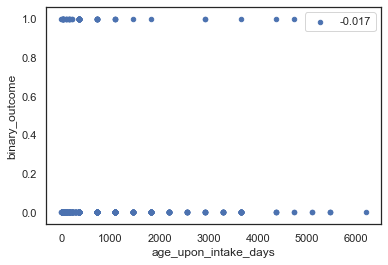

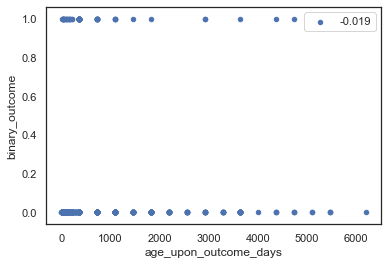

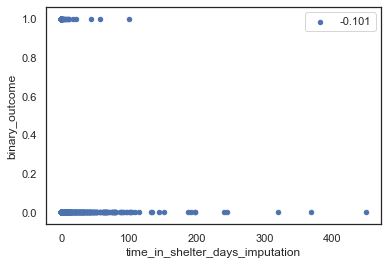

In [49]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_columns]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "binary_outcome"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="binary_outcome", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['binary_outcome']).sort_values('binary_outcome', ascending=False)
corr_df

### Interpretation of the results

age_upon_intake_days and age_upon_outcome_days
- Observing the plots, there does not seem to be a clear correlation between these features and the target feature. For this reason I have decided not use these features in my prediction models.

time_in_shelter_inputation
- Observing the plot we can see some correlation between this feature and the target feature that suggests that animals seem to have a bad binary outcome in the first few days. This insight could be communicated to the shelter to insure they have adequate monitoring during these first critical days.

## Plot interaction between continuous features and target feature

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:628: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  return self._values.ravel(order=order)



 intake_type
Index 	 Count
Stray 	 488
Owner Surrender 	 138
Public Assist 	 41
Wildlife 	 31
Euthanasia Request 	 2

 intake_condition
Index 	 Count
Normal 	 606
Nursing 	 22
Sick 	 31
Injured 	 36
Other 	 2
Feral 	 1
Aged 	 2

 animal_type_intake
Index 	 Count
Dog 	 378
Cat 	 278
Other 	 42
Bird 	 2

 neuter_status_intake
Index 	 Count
Not neutered 	 505
Neutered 	 195

 sex
Index 	 Count
Male 	 335
Female 	 290
nan 	 0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in long_scalars



 neuter_status_outcome
Index 	 Count
Neutered 	 457
Not neutered 	 243

 month_intake
Index 	 Count
5 	 73
1 	 30
3 	 53
10 	 72
12 	 57
6 	 84
9 	 66
8 	 72
4 	 50
11 	 53
7 	 61
2 	 29

 month_outcome
Index 	 Count
5 	 64
1 	 36
3 	 48
6 	 82
10 	 75
12 	 61
7 	 66
9 	 61
11 	 66
2 	 23
8 	 71
4 	 47

 found_city
Index 	 Count
Del Valle (TX) 	 23
Austin (TX) 	 566
Travis (TX) 	 64
Manor (TX) 	 16
Round Rock (TX) 	 1
Outside Jurisdiction 	 7
Pflugerville (TX) 	 14
Lakeway (TX) 	 3
Leander (TX) 	 1
Mustang Ridge (TX) 	 1
Jonestown (TX) 	 1
Lago Vista (TX) 	 1
Cedar Park (TX) 	 1
Webberville (TX) 	 1

 animal_breed
Index 	 Count
Australian Cattle Dog 	 15
Dachshund 	 7
other 	 154
Chihuahua  	 53
Domestic Mixed 	 261
Boxer 	 7
Siamese 	 8
Labrador Retriever 	 45
Bat 	 17
German Shepherd 	 19
Pit Bull 	 56
Border Collie 	 5
Raccoon 	 9
Great Pyrenees 	 7
Catahoula 	 9
Miniature Poodle 	 8
Yorkshire Terrier 	 13
Beagle 	 7

 animal_color
Index 	 Count
Brown 	 183
Red 	 16
Black 	 166
Tan

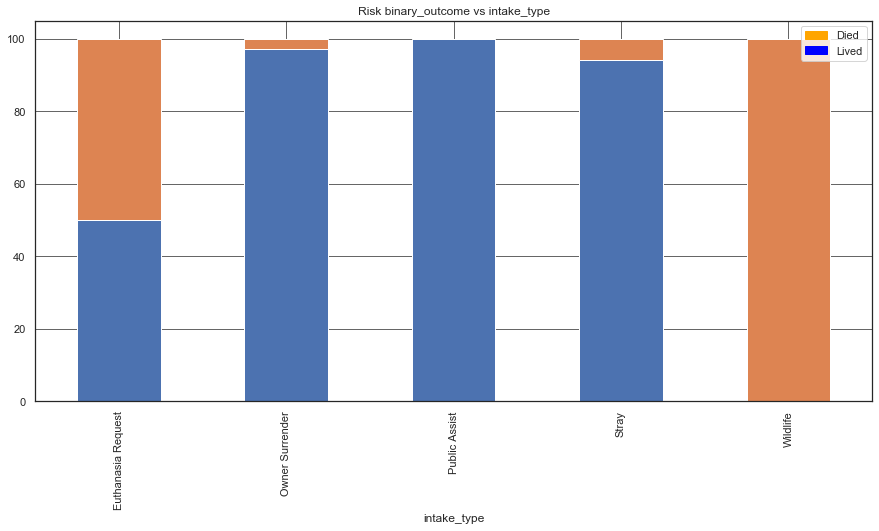

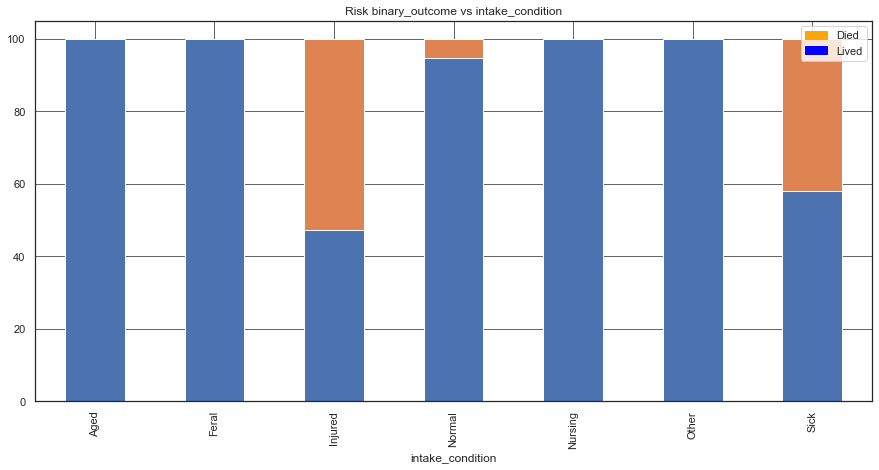

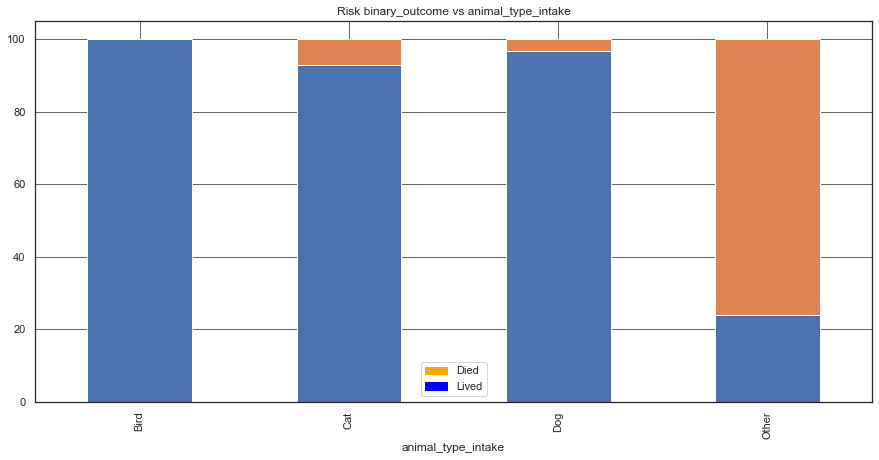

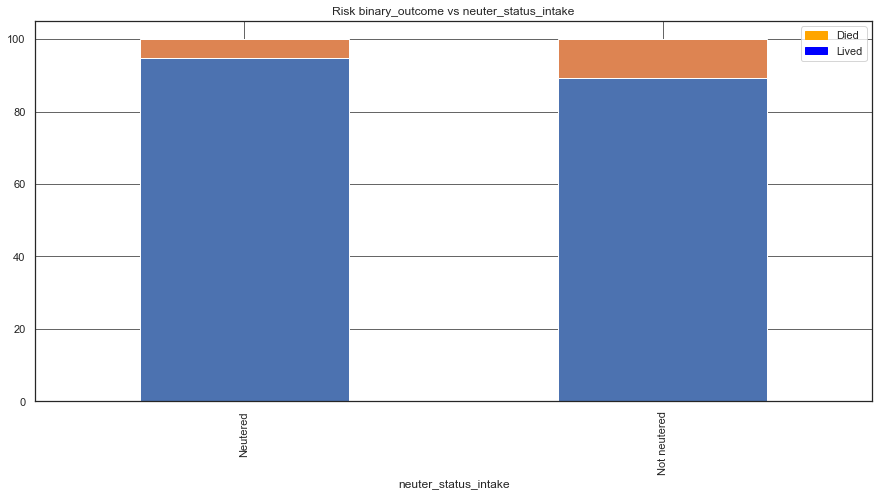

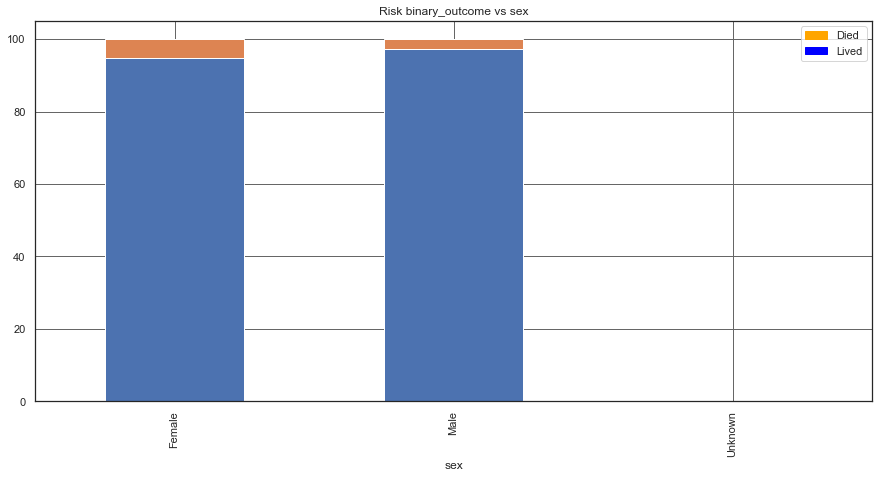

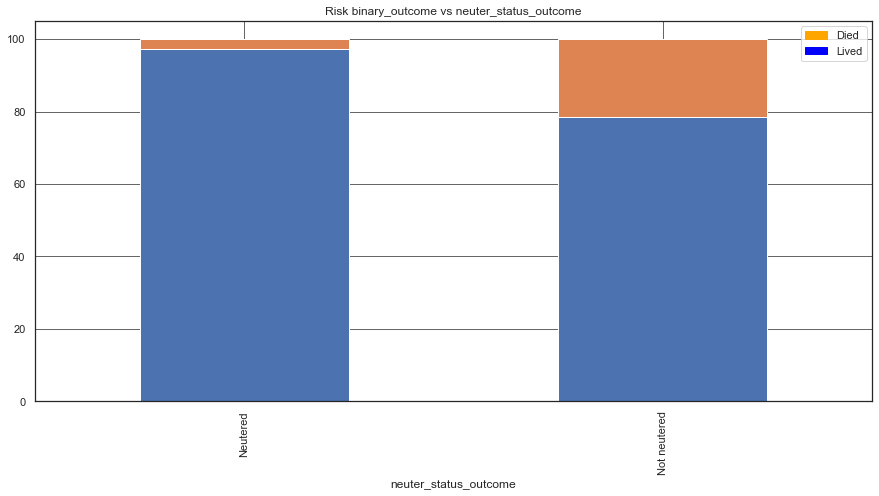

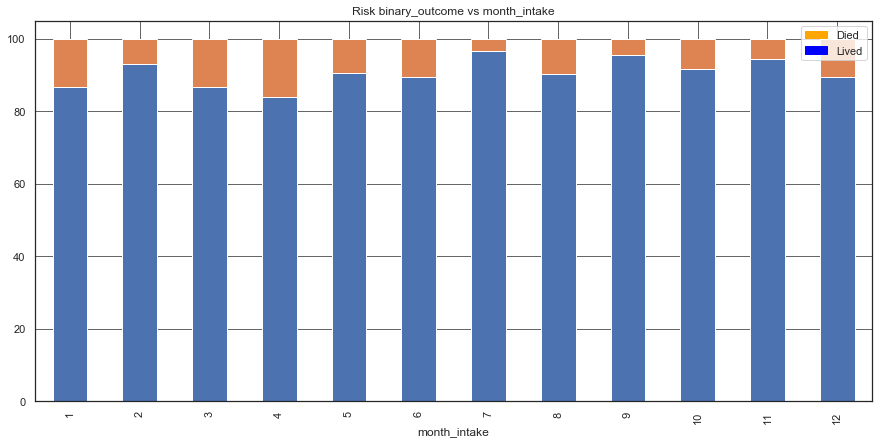

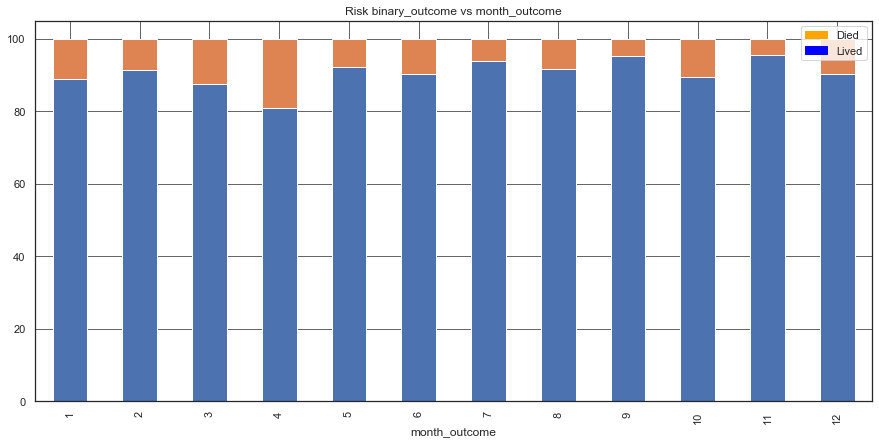

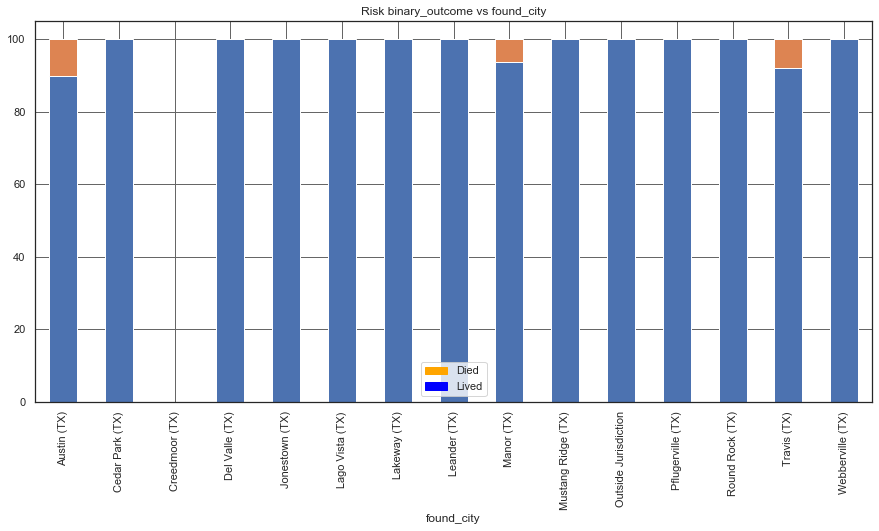

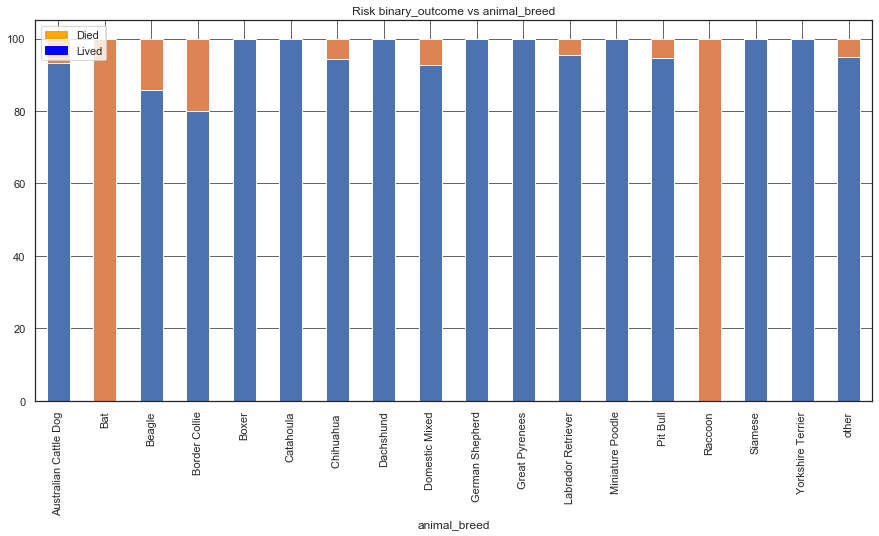

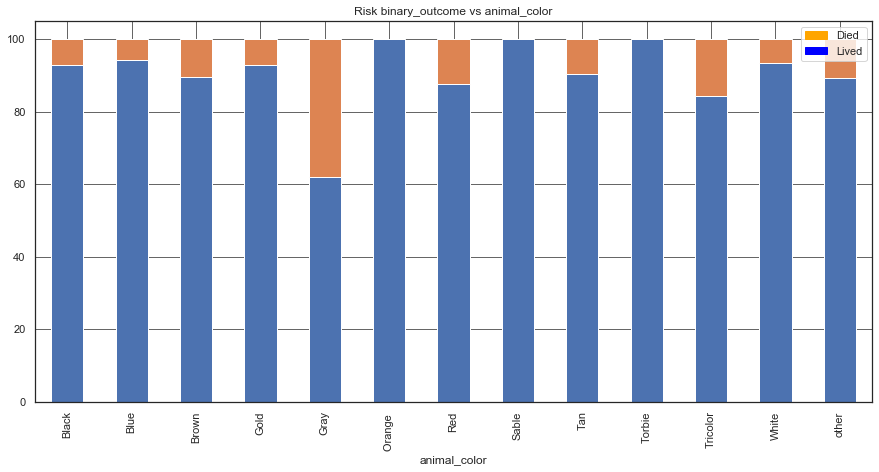

In [50]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")
#X_train[categorical_columns].columns

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)


# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_columns:
    # Using code from the module lab
    
    binary_outcome_resutl = pd.unique(df_temp[categorical_feature].ravel())

    # add new column and set values to zero
    df_temp['percent'] = 0

    #print header
    print("\n", categorical_feature)
    print("Index \t Count")

    # for each delinquency category
    for i in binary_outcome_resutl:

        count = df_temp[df_temp[categorical_feature] == i].count()['binary_outcome']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'binary_outcome']].groupby([categorical_feature,'binary_outcome']).sum()

    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"Risk binary_outcome vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='Died')
    blue_patch = mpatches.Patch(color='blue', label='Lived')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
#     plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    # add labels
#     my_plot.set_xlabel("Delinquency index")
#     my_plot.set_ylabel("% Risk")
#     my_plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

### Interpretation of the results

binary_outcome vs intake_condition
- Observing the plots we can see that for some intake conditions such as Injured or Sick, the percentage of bad binary outcome is a lot higher if compared to the other ones, this is expected.
- There must be caution when observing the percentage for animals in categories Other, Feral and Aged as there is not enough data in each category (together they male up 0.7% of the entire dataset). Without more data it is hard to say if these categories will have significant effect in predicting binary outcome.
- As there is more data for the other categories, we can observe that animals that are Normal have a much higher change of a positive binary outcome than animals that are Injured or Sick.
- For the reasons above, we can say it is likely that this feature will be useful in predicting binary outcome.

binary_outcome vs animal_type_intake
- Observing the plots we can see that a high percentage of animals classified as Other have a bad binary outcome. It is difficult to judge if this outcome for Other is expected or not, and would require domain expertise.
- However, this could mean that the shelter is more equipped to deal with animals classified as Cat, Dog or Bird. However, we should be careful with this analysis and observe if other features have a high correlation with animal_type_intake. This could be said due to the fact that Other is a very broad term. We should observe if animals in the Other category are also Injured or Sick in the intake_condition feture. We should also observe if these animals are in the category of Wildlife in the type_intake, as this could be a clue on the type of animal the shelter is not prepared to help.
- Without further analysis and combining features, it is likely that this feature by itself will not help in predicting binary outcome

binary_outcome vs neutered_status_intake
- Observing the plots we can see that animals that are Neutered on intake have a slightly better chance of a positive outcome, which is expected since animals that are neutered tend to live longer.
- Further analysis would be required, as one of the possibilities could be that animals that are already neutered on intake already have owners who take better care of their animals, thus showing the reason for the slightly higher percentage on positive outcome.
- Although there is sufficient data i.e. both categories have large sample size, without further analysis the difference between Neutered and Not neutered on intake might not be sufficient to predict binary outcome.

binary_outcome vs sex
- Observing the plots we can see that there is not a significant difference between Male And Female when it comes to binary outcome. However, we can see that Female have a slightly higher chance of a bad binary outcome, which is to be expected due to the possibility of birth complications the Female gender might have.
- This might suggest that this feature would not be helpful when predicting binary outcome even though there is sufficient data i.e. both categories have large sample size.

binary_outcome vs neuter_status_outcome
- Observing the plots we can see that animals that are Not neutered on outcome have a higher bad binary outcome. This is to be expected as we can infer that animals only get neutered while in the shelter if they have a good chance of surviving and/or being adopted (positive binary outcome).
- Caution must be observed for this feature as we do not have this information when the animal arrives at the shelter, this data is only known at some point after arrival.
- The points above suggest that this feature would not be helpful when predicting binary outcome even though there is sufficient data.

binary_outcome vs month_intake
- Observing the plots we can see a negative trend in binary outcome starting in March extending into April, but then trending in the opposite direction in May. After May it become difficult to find an apparent pattern based on the absolute numbers.
- However if we analyse further there is a notable trend in deltas between months. When the number of intake rises from one month to the next, there seems to be a rise in negative binary outcome and similarly, when there is a reduction in intake from the previous month to the next month, there seems to be a reduction in negative binary outcome. For example:
    * From February to March there is an 83% increase in the number of animal intake, and the number of bad binary outcome increase from 6.4% to 12.5%.
    * From June to July there is a 20% decrease in the number of animal intake, and the number of bad binary outcome decreases from 10% to 3%.
    <br>
This trend seems to be true for all months except December and January.
- This means that further analysis might be required for a better understanding. Maybe grouping the months in seasons or analysing the transition from one month to the next might give us a better understanding of the data.
- As is, this feature does not seem to be particularly promising, but could be useful to predict binary outcome with further data manipulation as specified above.

binary_outcome vs month_outcome
- Observing the plots we can see the same trend as we see in month_intake. This is expected since the median time_in_shelter_days is 4 days.
- One way of modifying the data for better analysis could be to get the difference between the number of animals that arrived and the number of animals that left the shelter (either with positive or negative binary outcome) on a certain month. This would give us more insight on what the trend might be if the shelter becomes more busy or less busy.
- As is, this feature does not seem to be particularly promising, but could be useful to predict binary outcome with further data manipulation as specified above.

binary_outcome vs found_city
- Observing the plots we can see that the negative binary_outcome for some cities found_city are none or close to none. On further inspection we can see that some of these places have a very small sample size as 80% of the animals are found in one location: Austin. 9% of animals were found in Travis and the rest 11% are scattered around 13 other cities.
- This means that the sample size for these 13 cities might be too small for a prediction to be useful.
- The points above suggest that this feature would not be helpful when predicting binary outcome as there is insufficient data for some cities.

binary_outcome vs animal_breed
- Observing the plots we can see that there is a high number of animals classified as Domestic Mixed (almost 40%). This happens because most animals classified as Cats are also classified as Domestic Mixed. There are not many cats that are different breed as in second place in numbers we have Siamese (1%). This is expected and might mean that we do not have enough diversity in categories for this feature to be helpful.
- As for the animals classified as dogs, the numbers on breed are more evenly distributed, with higher negative binary outcome for Beagles and Border Collies.
- However, we should make an observation that this could be due to the fact that the sample size for these breeds is very small (together they make up for 0.2% of all breeds).
- Animals classified as Bat and Raccoon have 100% negative binary outcome, which could be indicative that the shelter is not well equipped to deal with animals in these categories.
- If we take into consideration only the breeds that occur more often, this feature can be helpful when predicting binary outcome for dogs. There could be some uncertainty when it comes to cats, as most of the data comes from one large group.

binary_outcome vs animal_color
- Observing the plots we can see that some colors such as Brown, Gray and Tricolor have a high negative binary outcome if compared to the other colors. This is surprising as I did not expect colors to be an indicative of either good or bad binary_outcome.
- Caution should be observed when dealing with this feature, as there is also small sample size for some colors.
- An option could be to discard some of the colors in the group mentioned above, as they make up for only 2% of the data.
- The points above might suggest that this feature is potentially a helpful feature to predict binary_outcome

binary_outcome vs intake_type
- Observing the plots we can see that 100% of animals categorised as Wildlife have a negative binary_outcome. This could be due to the fact that the shelter is not equipped to deal with this kind of animal. Another interesting observation is that only around 50% of the animals brought into the shelter categorised as Euthanasia Request have a negative binary_outcome.
- However, caution should be observed when taking into consideration the category of Euthanasia Request, as the sample size is very small with only 0.2% of animals being in this category.
- If comparing animals categorised as Owner Surrender and Stray, we can see that Strays are slightly more likely to have a negative binary outcome.
- This feature could be helpful in predicting binary_outcome.



Current status: based on the analysis above I have decided to drop sex, neuter_status_outcome and found_city.

### Drop features based on the decisions made above
- Create a copy of the original df before I drop the features in case I need to revert to the original dataset.
- Drop features from new dataset

In [51]:
low_correlation_features = [df['age_upon_intake_days'], 
                            df['age_upon_outcome_days'],
                           df['sex'],
                           df['neuter_status_outcome'],
                           df['found_city']]

In [52]:
df_new = df.copy()
df_new = df_new.drop('age_upon_intake_days', 1)
df_new = df_new.drop('age_upon_outcome_days', 1)
df_new = df_new.drop('sex', 1)
df_new = df_new.drop('neuter_status_outcome', 1)
df_new = df_new.drop('found_city', 1)

#### For the reasons metioned in the interpretation of the results above, I have decided to keep the following features:
intake_condition, animal_type_intake, neutered_status_intake ,month_intake, animal_breed, animal_color, intake_type

## Prepare the dataset to be used in our models

Now that we have prepared the data, there is additional manipulation required before I can start running the first model.
- BINARY ENCODING: Converting all the categorical features into dummy values: the machine learning algorithm I will use requires numbers as input. Because by nature the values in a categorical feature are not numbers, we need to convert them into numbers so they can be used in our model.

In [53]:
# set up dummies features
df_new = pd.get_dummies(df_new)
df_new.dtypes

binary_outcome                       int64
time_in_shelter_days_imputation    float64
intake_type_Euthanasia Request       uint8
intake_type_Owner Surrender          uint8
intake_type_Public Assist            uint8
                                    ...   
animal_color_Tan                     uint8
animal_color_Torbie                  uint8
animal_color_Tricolor                uint8
animal_color_White                   uint8
animal_color_other                   uint8
Length: 75, dtype: object

#### Now I wil create a list of the continous and categorical features without the target feature:

In [54]:
# create a list of the continuous feature without the target feature
continuous_columns = df_new.select_dtypes(include=['float64']).columns.tolist()
continuous_columns

['time_in_shelter_days_imputation']

In [55]:
categorical_columns = df_new.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['intake_type_Euthanasia Request',
 'intake_type_Owner Surrender',
 'intake_type_Public Assist',
 'intake_type_Stray',
 'intake_type_Wildlife',
 'intake_condition_Aged',
 'intake_condition_Feral',
 'intake_condition_Injured',
 'intake_condition_Normal',
 'intake_condition_Nursing',
 'intake_condition_Other',
 'intake_condition_Sick',
 'animal_type_intake_Bird',
 'animal_type_intake_Cat',
 'animal_type_intake_Dog',
 'animal_type_intake_Other',
 'neuter_status_intake_Neutered',
 'neuter_status_intake_Not neutered',
 'month_intake_1',
 'month_intake_2',
 'month_intake_3',
 'month_intake_4',
 'month_intake_5',
 'month_intake_6',
 'month_intake_7',
 'month_intake_8',
 'month_intake_9',
 'month_intake_10',
 'month_intake_11',
 'month_intake_12',
 'month_outcome_1',
 'month_outcome_2',
 'month_outcome_3',
 'month_outcome_4',
 'month_outcome_5',
 'month_outcome_6',
 'month_outcome_7',
 'month_outcome_8',
 'month_outcome_9',
 'month_outcome_10',
 'month_outcome_11',
 'month_outcome_12',
 'anima

#### I will now join all the features together in one single varible:

In [56]:
features = continuous_columns + categorical_columns
features

['time_in_shelter_days_imputation',
 'intake_type_Euthanasia Request',
 'intake_type_Owner Surrender',
 'intake_type_Public Assist',
 'intake_type_Stray',
 'intake_type_Wildlife',
 'intake_condition_Aged',
 'intake_condition_Feral',
 'intake_condition_Injured',
 'intake_condition_Normal',
 'intake_condition_Nursing',
 'intake_condition_Other',
 'intake_condition_Sick',
 'animal_type_intake_Bird',
 'animal_type_intake_Cat',
 'animal_type_intake_Dog',
 'animal_type_intake_Other',
 'neuter_status_intake_Neutered',
 'neuter_status_intake_Not neutered',
 'month_intake_1',
 'month_intake_2',
 'month_intake_3',
 'month_intake_4',
 'month_intake_5',
 'month_intake_6',
 'month_intake_7',
 'month_intake_8',
 'month_intake_9',
 'month_intake_10',
 'month_intake_11',
 'month_intake_12',
 'month_outcome_1',
 'month_outcome_2',
 'month_outcome_3',
 'month_outcome_4',
 'month_outcome_5',
 'month_outcome_6',
 'month_outcome_7',
 'month_outcome_8',
 'month_outcome_9',
 'month_outcome_10',
 'month_outco

### Setting up the train/test split
- I will split the data nowusing the dataset with the dummy values
- Our target feture will be in dataframe "Y" and the remaining features will be stored in dataframe "X"
- I will then split both into training subset and test

In [57]:
# y is the target
y = df_new["binary_outcome"]
# X is all the other features
X = df_new.drop(["binary_outcome"],1)
# Split the dataset into two datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("Original range: ",df_new.shape[0])
print("Training range (70%):\t 0 to", round(X_train.shape[0]))
print("Test range (30%): \t", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

Original range:  1000
Training range (70%):	 0 to 700
Test range (30%): 	 700 to 1000


### I will now double check all the features in X and the Target feature in Y:

In [58]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
      time_in_shelter_days_imputation  intake_type_Euthanasia Request  \
731                              4.0                               0   
716                              4.0                               0   
640                              0.0                               0   
804                              5.0                               0   
737                              4.0                               0   

     intake_type_Owner Surrender  intake_type_Public Assist  \
731                            0                          0   
716                            1                          0   
640                            0                          0   
804                            0                          0   
737                            0                          0   

     intake_type_Stray  intake_type_Wildlife  intake_condition_Aged  \
731                  1                     0                      0   
716              

In [59]:
X_train.head(5)

,time_in_shelter_days_imputation,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,intake_condition_Aged,intake_condition_Feral,intake_condition_Injured,intake_condition_Normal,...,animal_color_Gold,animal_color_Gray,animal_color_Orange,animal_color_Red,animal_color_Sable,animal_color_Tan,animal_color_Torbie,animal_color_Tricolor,animal_color_White,animal_color_other
731,4.0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
716,4.0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
640,0.0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
804,5.0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
737,4.0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Reseting indexes
- We can see above that the X_train's indexes are not consecultive, the same is true for y_train, X_test, y_test
- As we need to merge the dataframes in the futre, I will need to deal with this now, otherwise the merging will be affected. The way to do this is to reset the indexes so they become consecultive once more.

In [60]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,time_in_shelter_days_imputation,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,intake_condition_Aged,intake_condition_Feral,intake_condition_Injured,intake_condition_Normal,...,animal_color_Gold,animal_color_Gray,animal_color_Orange,animal_color_Red,animal_color_Sable,animal_color_Tan,animal_color_Torbie,animal_color_Tricolor,animal_color_White,animal_color_other
0,4.0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4.0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0.0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5.0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,4.0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


As we can see above, the indexes are now reset, so merging the datasets later should not be a problem. I can now start working on my predictive models.

## 2.0 Linear Regression Model
## 2.1 Using only the features selected in the previous part, I will now train a linear regression model.
The training stage estimates (learns) the parameters.

In [61]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

## 2.2 Below I will print the coefficients learned by the model and discuss their role in the model 

In [62]:
# Print the weights learned for each feature.
print("\nFeatures: \n", X_train.columns)
print("\nCoeficients: \n", multiple_linreg.coef_)
print("\nIntercept: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients together: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features: 
 Index(['time_in_shelter_days_imputation', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'intake_type_Wildlife', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Sick',
       'animal_type_intake_Bird', 'animal_type_intake_Cat',
       'animal_type_intake_Dog', 'animal_type_intake_Other',
       'neuter_status_intake_Neutered', 'neuter_status_intake_Not neutered',
       'month_intake_1', 'month_intake_2', 'month_intake_3', 'month_intake_4',
       'month_intake_5', 'month_intake_6', 'month_intake_7', 'month_intake_8',
       'month_intake_9', 'month_intake_10', 'month_intake_11',
       'month_intake_12', 'month_outcome_1', 'month_outcome_2',
       'month_outcome_3', 'month_outcome_4', 'month_outcome_5',
       'month_outcome_6', 'month_outcom

### Interpreting Linear Regression Model
Linear Regression can be used for predictive analysis. It is a way of modelling the relationship between a set of independent variables and a dependent variable. In this exercise multiped liner regression is being applied using the features of animals prepared above as the set of independent variables and using binary outcome as the dependent variable.

The formula below works to find the best fit and minimize the errors:
- Target_feature = W0+W1 * feature_1 + W2 * feature_2 + ... + Wn * feature_n
- The intercept is the expected mean value of Y when all X=0:
    * The intercept is 0.27482185446216495
- The coefficients for each feature can be seen above.
    * The data model prediction is the sum of the coefficients + the intercept 
    * The max possible impact on the prediction can be calculated by multiplying the maximum value in the feature with feature’s coefficient. For example:
    * The max value in time_in_shelter_days_imputation is 424, its coefficient is -0.00021655497825007826, so the max possible impact this feature can have on prediction is -0.09181931077803318.
    * Similarly for categorical features the max possible value for intake_condition_Sick is 1 and its coefficient is 0.16344841064762472 so the max possible impact this feature can have on prediction is 0.16344841064762472. In comparison in intake_type_Stray, which has a coefficient of -0.15143258722858524. We can see that an animal taken in sick will have a greater positive impact on the dependent variable, which will make a bad outcome more likely.
-	Caution should be exercised when applying multiple linear regression due to its sensitivity to outliers. One of the features time_in_shelter_days does have outliers

## 2.3 Print the predicted target feature value for the first training examples and interpretation of the evaluation metrics.
#### Next is the prediction stage.
The model will apply the weights (learned during training) to the features in order to get a predictd target.
<br>
I will print the first 10 trainig examples below.
<br>
If the prediction value is >= 0.5 then it is true and will print 1 for negative binary outcome. If it is <0.5 it will print 0 for positive binary outcome.

In [63]:
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   binary_outcome  Predicted
0               0        0.0
1               0        0.0
2               0        0.0
3               0        0.0
4               0        0.0
5               0        0.0
6               0        0.0
7               0        0.0
8               0        0.0
9               0        0.0


#### Metrics evaluation
- I will print now a few classification evaluation measures.

In [64]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9557142857142857
Confusion matrix: 
 [[635   1]
 [ 30  34]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      1.00      0.98       636
           1       0.97      0.53      0.69        64

    accuracy                           0.96       700
   macro avg       0.96      0.76      0.83       700
weighted avg       0.96      0.96      0.95       700



#### Interpretation of the results

- Accuracy
    * This function computes accuracy. This model has an accuracy of 95.6%.
- Confusion matrix
    * 635 is the number of true 0s predicted - animals that lived and were predicted lived
    * 1 is the number of false 1s predicted - animals that lived and were predicted as died
    * 30 is the number of false 0s predicted - animals that died and were predicted as lived
    * 34 is the numner of true 1s predicted - animals that died and were predicted as died.

- Precision
    * Out of the total number of 0s predicted (665), 635 were correctly predicted and 30 were incorrectly predicted. The precision of 0s predicted above (0.95) is derived from this calculation: 635/(635+30) = 0.9548872180451128.
    * Out of the total number of 1s predicted (35), 34 were correctly predicted and 1 was incorrectly predicted. The precision of 1s predicted above (0.97) is derived from this calculation: 34/(34+1) = 0.9714285714285714.
    
- Recall
    * The true total of 0s is 636. 635 were correctly predicted as 0s. The recall value for 0s (1.00) is derived from this calculation: 635/636 = 0.9984276729559748.
    * The true total of 1s is 64. 34 were correctly predicted as 1s. The recall value for 1s (0.53) is derived from this calculation: 34/64 = 0.53125.

- F1 score
    * F1 is a function of Precision and Recall, it is the ballance between Precision and Recall
    * F1 score can be derived from the formula 2x (precision * recall) / (precision + recall)
    * The F1 score for 0s following the above formula is 2 * (0.9548872180451128 * 0.9984276729559748) / (0.9548872180451128 + 0.9984276729559748) = 0.9761721752498078
    * The F1 score for 0s following the above formula is 2 * (0.9984276729559748 * 0.53125) / (0.9984276729559748 + 0.53125) = 0.6934986509058203

- In predicting successful animal outcomes the model should have predicted that 636 animals lived, but only predicted that 635 lived. In this regard the model is generally quite accurate, with a slight pessimistic bias. 
- In predicting unsuccessful outcomes the model should have predicted that 64 died, but only predicted that 34 died. In this regard, the model has a significant optimistic bias.
- As we relate the results of the prediction model back to the business domain, an optimistic bias on 1s is extremely undesirable. The animal shelter may need to take life or death decisions for animals at risk. It would be better to have a marginally pessimistic bias that predicts the animal will die (but it actually lives), rather than an optimistic bias that the animal will live (but it actually dies). The ramifications of an optimistic prediction could be far worse.
- This model performs poorly because even though the accuracy could appear high (95%), for this case we should also look at the F1 score as the accurate prediction of both 0s and 1s is important. We should also take into consideration that the accurate prediction of 1s is paramount, so focusing on the recall for 1s could be crucial for evaluating this model.

## 2.4 Evaluate the model using classification evaluation measures on the hold-out (test set)
#### I will also compare these results with the evaluation results obtained on the training set. Furthermore I will compare these results with a cross-validation model and discuss my findings.

#### Evaluation metrics based on test dataset

In [65]:
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   binary_outcome  Predicted
0               0        0.0
1               0        0.0
2               0        0.0
3               0        0.0
4               0        0.0
5               0        0.0
6               0        0.0
7               0        0.0
8               0        0.0
9               0        0.0


In [66]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9566666666666667
Confusion matrix: 
 [[278   0]
 [ 13   9]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98       278
           1       1.00      0.41      0.58        22

    accuracy                           0.96       300
   macro avg       0.98      0.70      0.78       300
weighted avg       0.96      0.96      0.95       300


==================== Train Data ======================
Accuracy:  0.9557142857142857
Confusion matrix: 
 [[635   1]
 [ 30  34]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.95      1.00      0.98       636
           1       0.97      0.53      0.69        64

    accuracy                           0.96       700
   macro avg       0.96      0.76      0.83       700
weighted avg       0.96      0.96      0.95       700



#### Interpretation of test results and comparison with training results
- Accuracy
    - The accuracy of the test data is marginally higher 95.67% vs 95.57%. 
- Precision
    - The precision score for predicting 0s (lived) has increased from 95% to 96%.
    - The precision score for predicting 1s (died) has decreased from 97% to 96%.
- Recall
    - The recall score for predicting 0s has remained the same, 100%.
    - The recall score for predicting 1s has decreased from 53% to 41%.
- F1 score
    - The f1 score for predicting 0s has remained the same, 98%.
    - The f1 score for predicting 1s has decreased from 69% to 58%.

- In comparison to the Train dataset, the Test dataset's values have either stayed the same or decreased, with the exception of the precision score for 0s, which increased by 1%.
- It is important to point out that, as discussed in the interpretation of the results in the previous section, the most important values for evaluating this model suffered a considerable reduction: the Recall for 1s and the F1 score for 1s.
- This is a key indicator that the model would not perform well in the animal shelter screnario. However I will use some cross validation as a way of making further comparisons.

### Cross validation

- For the cross validation, the same evaluation as above is performed multiple times. Each time, before the evaluation is performed, the dataset is shuffled so the Test and the Training datasets are different each time.
- The results will be store in a dictionary for later analysis.
- Below is the cross validation function:

In [67]:
# code taken from sample_solution given by lecturer
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The random state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='Accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='Precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='F1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='Recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

Now the funtion below will do a 10 fold cross validation and store the results for later analysis.

In [68]:
# code taken from sample_solution given by lecturer
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['Accuracy','Precision','Recall', 'F1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Calling the function and showing the results below:

In [69]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation")
linRegDF

Mean results from 10 fold cross validation


,Linear_Regression
Accuracy,0.947000
Precision,0.960417
Recall,0.425935
F1,0.586129


The results for accuracy are slightly lower than the results we see in the previous section.

## 3.0 Logistic Regression   

## 3.1 Train a logistic regression model using only the descriptive features selected from part 1

In [70]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 3.2 Print out the coefficients learned by the model and discuss

In [71]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['time_in_shelter_days_imputation', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'intake_type_Wildlife', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Sick',
       'animal_type_intake_Bird', 'animal_type_intake_Cat',
       'animal_type_intake_Dog', 'animal_type_intake_Other',
       'neuter_status_intake_Neutered', 'neuter_status_intake_Not neutered',
       'month_intake_1', 'month_intake_2', 'month_intake_3', 'month_intake_4',
       'month_intake_5', 'month_intake_6', 'month_intake_7', 'month_intake_8',
       'month_intake_9', 'month_intake_10', 'month_intake_11',
       'month_intake_12', 'month_outcome_1', 'month_outcome_2',
       'month_outcome_3', 'month_outcome_4', 'month_outcome_5',
       'month_outcome_6', 'month_ou

#### Interpreting the results:


#### 3.4 Printing 100 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 100 training examples based on training data

In [72]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(100))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0                0          0
1                0          0
2                0          0
3                0          0
4                0          0
..             ...        ...
95               0          0
96               0          0
97               0          0
98               0          0
99               0          0

[100 rows x 2 columns]


#### 3.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [73]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.96
Confusion matrix: 
 [[635   1]
 [ 27  37]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98       636
           1       0.97      0.58      0.73        64

    accuracy                           0.96       700
   macro avg       0.97      0.79      0.85       700
weighted avg       0.96      0.96      0.96       700



#### Interpretation of results

#### 3.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [74]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    binary_outcome  Predicted
0                0          0
1                0          0
2                0          0
3                0          0
4                0          0
5                0          0
6                0          0
7                0          0
8                0          0
9                0          0
10               0          0
11               0          0
12               0          0
13               0          0
14               0          0
15               0          0
16               0          0
17               0          0
18               0          0
19               0          0


In [75]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.96
Confusion matrix: 
 [[277   1]
 [ 11  11]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98       278
           1       0.92      0.50      0.65        22

    accuracy                           0.96       300
   macro avg       0.94      0.75      0.81       300
weighted avg       0.96      0.96      0.95       300

==================== Train Data =======================
Accuracy:  0.96
Confusion matrix: 
 [[635   1]
 [ 27  37]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98       636
           1       0.97      0.58      0.73        64

    accuracy                           0.96       700
   macro avg       0.97      0.79      0.85       700
weighted avg       0.96      0.96      0.96       700



#### Interpretation of test results and comparison with training results 


#### 3.7 Cross validation
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [76]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarised below

In [77]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Mean results from 10 fold cross validation are:


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

,Logistic_Regression
accuracy,0.953000
precision,0.910000
recall,0.490278
f1,0.628548


## Random Forest Model


### 4.1 Train a random forest model using only the descriptive features selected from part 1 above 
- A random forest model will now be trained on our test data. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated

In [78]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=1, verbose=0,
                       warm_start=False)

### 4.2 Understanding the Random Forest model

####  4.2.1  Train Decision tree
We will train 2 decision trees, with the same test data 
- One with max_depth=4 and the other max_depth=10
- Max depth determines how deep a decision tree can go before it must give an answer

In [79]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
Max depth 10: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')


####  4.2.2  Display Decision tree
We will create graph of each tree and store as an image

# TO DO!!!!

In [80]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

/bin/sh: dot: command not found
/bin/sh: dot: command not found


In [81]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
5,intake_type_Wildlife,0.160358
0,time_in_shelter_days_imputation,0.112038
16,animal_type_intake_Other,0.089447
44,animal_breed_Bat,0.065110
9,intake_condition_Normal,0.046427
...,...,...
68,animal_color_Sable,0.000085
13,animal_type_intake_Bird,0.000062
48,animal_breed_Catahoula,0.000025
50,animal_breed_Dachshund,0.000003


### 4.4 Printing 100 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 100 training examples. 

In [82]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(100)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


### 4.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [83]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9985714285714286
Confusion matrix: 
 [[636   0]
 [  1  63]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      1.00      1.00       636
           1       1.00      0.98      0.99        64

    accuracy                           1.00       700
   macro avg       1.00      0.99      1.00       700
weighted avg       1.00      1.00      1.00       700



Interpretation of results
- The model has learned the results. This is clearly overfitting

### 4.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [84]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [85]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9466666666666667
Confusion matrix: 
 [[276   2]
 [ 14   8]]
Classification report:
                precision    recall  f1-score   support

           0       0.95      0.99      0.97       278
           1       0.80      0.36      0.50        22

    accuracy                           0.95       300
   macro avg       0.88      0.68      0.74       300
weighted avg       0.94      0.95      0.94       300

==================== Train Data =======================
Accuracy:  0.9985714285714286
Confusion matrix: 
 [[636   0]
 [  1  63]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      1.00      1.00       636
           1       1.00      0.98      0.99        64

    accuracy                           1.00       700
   macro avg       1.00      0.99      1.00       700
weighted avg       1.00      1.00      1.00       700



### 4.7 Cross validation
- We will preform cross validation and store the results in a dictionary for later use

In [86]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

In [87]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.955000
precision,0.945714
recall,0.512500
f1,0.649810


### 4.8 Out of bag accuracy
- This is the out of bag error estimate 
- It is an internal error estimate of a random forest as it is being constructed.
- It is used as an additional measure and should be line with the cross validation results
- This is generally expected to be the lowest

In [88]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9528571428571428

## 5 Improving Predictive Models

In [89]:
ResultsDF = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Linear_Regression,Logistic_Regression,Random_Forests
Accuracy,0.947000,NaN,NaN
F1,0.586129,NaN,NaN
Precision,0.960417,NaN,NaN
Recall,0.425935,NaN,NaN
accuracy,NaN,0.953000,0.955000
f1,NaN,0.628548,0.649810
precision,NaN,0.910000,0.945714
recall,NaN,0.490278,0.512500


In [90]:
good_count = y_test[y_test == 1].count()
bad_count = y_test[y_test == 0].count()
total = good_count+ bad_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number negative outcome:\t {good_count}\t{round(good_count/len(y_test)*100,2)}%')
print(f'Total number positive outcome:\t {bad_count}\t{round(bad_count/len(y_test)*100,2)}%')

From original dataset: 		Count 300
Total number negative outcome:	 22	7.33%
Total number positive outcome:	 278	92.67%
